In [1]:
from dotenv import load_dotenv
import os

load_dotenv()
api_key = os.getenv("GOOGLE_API_KEY")

In [2]:

from google import genai
import chromadb.utils.embedding_functions as embedding_functions
import chromadb


chroma_client = chromadb.PersistentClient(path="db/")
google_ef  = embedding_functions.GoogleGenerativeAiEmbeddingFunction(api_key=api_key,model_name='models/text-embedding-004')
client = genai.Client(api_key=api_key)


c:\Users\sameh\AppData\Local\Programs\Python\Python310\lib\site-packages\google\api_core\_python_version_support.py:266: FutureWarning: You are using a Python version (3.10.1) which Google will stop supporting in new releases of google.api_core once it reaches its end of life (2026-10-04). Please upgrade to the latest Python version, or at least Python 3.11, to continue receiving updates for google.api_core past that date.
  warnings.warn(message, FutureWarning)


In [ ]:
collection = chroma_client.get_or_create_collection(name="MKdocGPTv2", embedding_function=google_ef)

In [4]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

splitter = RecursiveCharacterTextSplitter(
    separators=["\n\n", "\n", " ", ""],
    chunk_size=500,
    chunk_overlap=50
)

In [5]:
import os
import pickle
from langchain_community.document_loaders import UnstructuredMarkdownLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from tqdm import tqdm

all_texts = []
all_metadatas = []
all_ids = []

for mdFile in tqdm(os.listdir("UserGuide"), desc="Loading Markdown Files"):
    if not mdFile.endswith(".md"):
        continue
    loader = UnstructuredMarkdownLoader(f"UserGuide/{mdFile}")
    docs = loader.load()
    chunks = splitter.split_documents(docs)

    all_texts.extend([c.page_content for c in chunks])
    all_metadatas.extend([{"source": mdFile, "section": c.metadata.get("section", "unknown")} for c in chunks])
    all_ids.extend([
        f"{os.path.splitext(mdFile)[0]}-s{c.metadata.get('section', '0')}-c{i}"
        for i, c in enumerate(chunks)
    ])

# Save to file
with open("split_data.pkl", "wb") as f:
    pickle.dump((all_texts, all_metadatas, all_ids), f)

print("✅ Data saved to split_data.pkl")

Loading Markdown Files: 100%|██████████| 9/9 [00:06<00:00,  1.43it/s]

✅ Data saved to split_data.pkl


In [6]:
import threading
import pickle

# === Load split data ===
with open("split_data.pkl", "rb") as f:
    all_texts, all_metadatas, all_ids = pickle.load(f)
# === Dynamic thread and batch settings ===
print(f"✅ Loaded {len(all_texts)} chunks.")
NUM_WORKERS = 4
BATCH_SIZE = 30
total = len(all_texts)
# === Setup shared tqdm and lock ===

✅ Loaded 220 chunks.


In [7]:
import time
def embed_and_insert(start_idx: int, end_idx: int):
    texts = all_texts[start_idx:end_idx]
    metadatas = all_metadatas[start_idx:end_idx]
    ids = all_ids[start_idx:end_idx]
    
    print(f"✅ Processing {start_idx} to {end_idx} ({len(texts)} chunks)")

    # Check which IDs already exist in the collection
    try:
        existing = collection.get(ids=ids)
        existing_ids = set(existing["ids"])
    except Exception as e:
        print(f"⚠️ Could not fetch existing IDs: {e}")
        existing_ids = set()

    # Filter out already existing IDs
    filtered_texts, filtered_metadatas, filtered_ids = [], [], []
    for t, m, i in zip(texts, metadatas, ids):
        if i not in existing_ids:
            filtered_texts.append(t)
            filtered_metadatas.append(m)
            filtered_ids.append(i)

    if not filtered_ids:
        print("⏩ All IDs already exist. Skipping batch.")
        return

    try:
        collection.add(documents=filtered_texts, metadatas=filtered_metadatas, ids=filtered_ids)
    except Exception as e:
        print(f"❌ Retry after error: {e}")
        time.sleep(60)
        try:
            collection.add(documents=filtered_texts, metadatas=filtered_metadatas, ids=filtered_ids)
        except Exception as e:
            print(f"❌ Permanent failure: {e}")
    
    time.sleep(60)

In [8]:
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm

total = len(all_texts)
futures = []
with ThreadPoolExecutor(max_workers=NUM_WORKERS) as executor:
    for i in range(0, total, BATCH_SIZE):
        futures.append(executor.submit(embed_and_insert, i, min(i + BATCH_SIZE, total)))

    for _ in tqdm(as_completed(futures), total=len(futures), desc="Embedding Chunks", unit="batch"):
        try:
            _.result()
        except Exception as e:
            print(f"❌ Thread failed: {e}")

print("✅ Indexing completed.")

✅ Processing 0 to 30 (30 chunks)
✅ Processing 30 to 60 (30 chunks)
✅ Processing 60 to 90 (30 chunks)
✅ Processing 90 to 120 (30 chunks)


Embedding Chunks:   0%|          | 0/8 [00:00<?, ?batch/s]

Embedding Chunks:  38%|███▊      | 3/8 [01:09<01:30, 18.00s/batch]

✅ Processing 120 to 150 (30 chunks)
✅ Processing 150 to 180 (30 chunks)
✅ Processing 180 to 210 (30 chunks)
✅ Processing 210 to 220 (10 chunks)


Embedding Chunks: 100%|██████████| 8/8 [02:18<00:00, 17.33s/batch]

✅ Indexing completed.


In [9]:
collection.count()

220

In [10]:
collection.peek()

{'ids': ['choosing-your-theme-s0-c0',
  'choosing-your-theme-s0-c1',
  'choosing-your-theme-s0-c2',
  'choosing-your-theme-s0-c3',
  'choosing-your-theme-s0-c4',
  'choosing-your-theme-s0-c5',
  'choosing-your-theme-s0-c6',
  'choosing-your-theme-s0-c7',
  'choosing-your-theme-s0-c8',
  'choosing-your-theme-s0-c9'],
 'embeddings': array([[ 0.02015111, -0.01496877, -0.01668754, ...,  0.00864538,
          0.03934991,  0.03684254],
        [ 0.02139956, -0.00256717, -0.06498945, ...,  0.01845334,
          0.03236296,  0.01872844],
        [ 0.01194128, -0.03406274, -0.09367632, ...,  0.01908131,
         -0.02089335,  0.04790332],
        ...,
        [ 0.02526982,  0.00905213, -0.06511671, ...,  0.02249764,
          0.02830203,  0.05289757],
        [ 0.05844728,  0.02500959, -0.03592135, ...,  0.02841299,
          0.05527138,  0.05543047],
        [ 0.01595515, -0.012148  , -0.0605895 , ..., -0.0023787 ,
          0.01506894,  0.08968253]], shape=(10, 768)),
 'documents': ['Choosing

In [ ]:
collection.query(
    query_texts=["What is mkdoc?"],
    n_results=10,
)


{'ids': [['configuration-s0-c49',
   'configuration-s0-c22',
   'writing-your-docs-s0-c48',
   'writing-your-docs-s0-c18',
   'writing-your-docs-s0-c7',
   'writing-your-docs-s0-c4',
   'writing-your-docs-s0-c14',
   'writing-your-docs-s0-c30',
   'writing-your-docs-s0-c17',
   'writing-your-docs-s0-c33']],
 'embeddings': None,
 'documents': [['See the examples and what they produce:',
   'course, the User Guide points to a local MkDocs page.',
   'The first line should contain 3 or more backtick (`) characters, and the last line should contain the same number of backtick characters (`):\n\n```\nFenced code blocks are like Standard\nMarkdown’s regular code blocks, except that\nthey’re not indented and instead rely on\nstart and end fence lines to delimit the\ncode block.\n```\n\nWith this approach, the language can optionally be specified on the first line after the backticks which informs any syntax highlighters of the language used:',
   'Writing with Markdown\n\nMkDocs pages must be

In [12]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\sameh\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


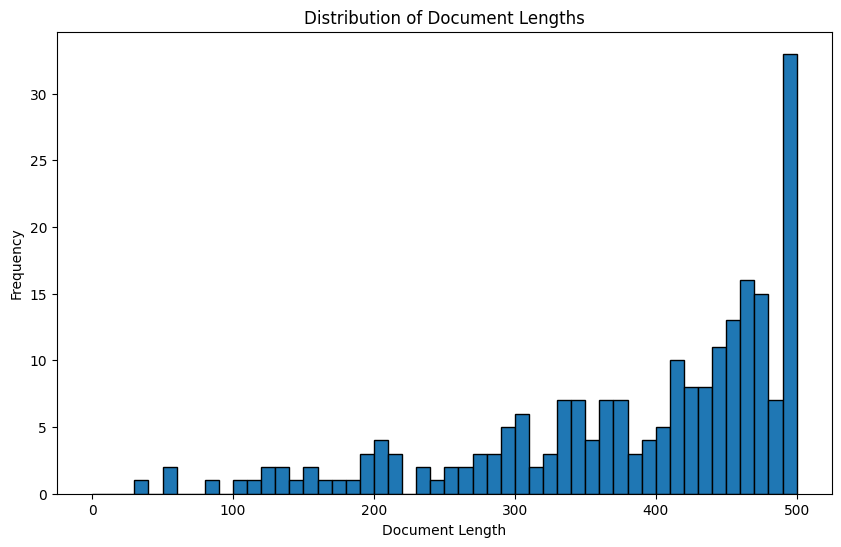

In [13]:
import matplotlib.pyplot as plt

documents = collection.peek(limit=total)

document_lengths = [len(doc) for doc in documents["documents"]]

plt.figure(figsize=(10, 6))
plt.hist(document_lengths, bins=range(0, max(document_lengths) + 10, 10), edgecolor='black')
plt.title("Distribution of Document Lengths")
plt.xlabel("Document Length")
plt.ylabel("Frequency")
plt.show()

In [14]:
'''
print(f"Total documents before removal: {collection.count()}")

filtered_ids = [doc_id for doc_id, length in zip(documents["ids"], document_lengths) if length >= 800]

try:
    collection.delete(ids=[doc_id for doc_id in documents["ids"] if doc_id not in filtered_ids])
    print("✅ Documents with length < 800 removed from the collection.")
except Exception as e:
    print(f"❌ Failed to remove documents: {e}")

print(f"Total documents after removal: {collection.count()}")
'''

'\nprint(f"Total documents before removal: {collection.count()}")\n\nfiltered_ids = [doc_id for doc_id, length in zip(documents["ids"], document_lengths) if length >= 800]\n\ntry:\n    collection.delete(ids=[doc_id for doc_id in documents["ids"] if doc_id not in filtered_ids])\n    print("✅ Documents with length < 800 removed from the collection.")\nexcept Exception as e:\n    print(f"❌ Failed to remove documents: {e}")\n\nprint(f"Total documents after removal: {collection.count()}")\n'

In [ ]:
collection.query(
    query_texts=["How to style using mkdoc?"],
    n_results=10,
)

{'ids': [['configuration-s0-c49',
   'writing-your-docs-s0-c48',
   'customizing-your-theme-s0-c2',
   'writing-your-docs-s0-c14',
   'writing-your-docs-s0-c47',
   'writing-your-docs-s0-c18',
   'writing-your-docs-s0-c33',
   'writing-your-docs-s0-c19',
   'writing-your-docs-s0-c45',
   'configuration-s0-c22']],
 'embeddings': None,
 'documents': [['See the examples and what they produce:',
   'The first line should contain 3 or more backtick (`) characters, and the last line should contain the same number of backtick characters (`):\n\n```\nFenced code blocks are like Standard\nMarkdown’s regular code blocks, except that\nthey’re not indented and instead rely on\nstart and end fence lines to delimit the\ncode block.\n```\n\nWith this approach, the language can optionally be specified on the first line after the backticks which informs any syntax highlighters of the language used:',
   'h1 {\n  color: red;\n}\n\nThen you need to add it to mkdocs.yml:\n\nextra_css:\n  - style.css\n\nAf